In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
import h5py
import copy
import pickle

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import print_wise
from data_preprocessing.preprocessing import format_in_trials, movie_paths #cut_excess_timepoints, create_bins, get_firing_rate, convert_gaze_coordinates

In [2]:
data_path = f"{paths["livingstone_lab"]}/tiziano/data"
resolution_Hz = 100
monkey_name = "red"
day = "0825"
npx = False
imec_n = 0
print(os.listdir(data_path))

['neural_venus_250922_imec0_100Hz.pkl', 'gaze_red_250902_plx_60Hz.pkl', 'gaze_red_250911_plx_100Hz.pkl', 'gaze_red_250828_plx_100Hz.pkl', 'gaze_red_250825_plx_100Hz.pkl', 'gaze_paul_250923_plx_100Hz.pkl', 'gaze_venus_250921_imec0_60Hz.pkl', 'gaze_louie_250920_imec0_60Hz.pkl', 'gaze_venus_250923_imec1_60Hz.pkl', 'neural_paul_250921_imec0_60Hz.pkl', 'neural_red_250902_plx_100Hz.pkl', 'neural_venus_250921_imec1_100Hz.pkl', 'neural_baby1_250919_imec0_100Hz.pkl', 'gaze_baby1_250921_imec0_100Hz.pkl', 'gaze_louie_250922_imec0_60Hz.pkl', 'gaze_red_250923_plx_60Hz.pkl', 'neural_venus_250920_imec1_60Hz.pkl', 'neural_venus_250923_imec0_100Hz.pkl', 'gaze_paul_250922_plx_60Hz.pkl', 'gaze_red_250821_plx_60Hz.pkl', 'neural_red_250822_plx_100Hz.pkl', 'gaze_red_250902_plx_100Hz.pkl', 'gaze_paul_250914_60Hz.pkl', 'neural_red_250914_plx_100Hz.pkl', 'neural_venus_250924_imec1_60Hz.pkl', 'neural_red_250824_plx_60Hz.pkl', 'neural_red_250831_plx_100Hz.pkl', 'neural_paul_250920_plx_60Hz.pkl', 'neural_paul_250

In [3]:
if npx: 
    neural_path = f"{data_path}/neural_{monkey_name}_25{day}_imec{imec_n}_{resolution_Hz}Hz.pkl"
    gaze_path = f"{data_path}/gaze_{monkey_name}_25{day}_imec{imec_n}_{resolution_Hz}Hz.pkl"
else: 
    neural_path = f"{data_path}/neural_{monkey_name}_25{day}_plx_{resolution_Hz}Hz.pkl"
    gaze_path = f"{data_path}/gaze_{monkey_name}_25{day}_plx_{resolution_Hz}Hz.pkl"
# end if npx: 

In [4]:
# loading of the data
with open(neural_path, "rb") as f:
    data_neural = pickle.load(f)
with open(gaze_path, "rb") as f:
    data_gaze = pickle.load(f)

In [5]:
print(data_gaze.keys())

dict_keys(['IMG_4672.mp4', 'IMG_4663.mp4', 'IMG_4669.mp4', 'IMG_4662.mp4', 'IMG_4667.mp4', 'IMG_4673.mp4', 'IMG_4656.mp4', 'IMG_4668.mp4', 'IMG_4655.mp4', 'IMG_4666.mp4', 'IMG_4671.mp4', 'IMG_4658.mp4', 'IMG_4664.mp4', 'IMG_4670.mp4', 'IMG_4665.mp4', 'IMG_4657.mp4', 'IMG_4661.mp4', 'IMG_4659.mp4', 'IMG_4660.mp4'])


In [ ]:
fn = 'IMG_4664.mp4'
eyes = data_gaze[fn][:2,:,0] # without fixations
neuro = data_neural[fn][:,:,0]
fixations_bin = data_gaze[fn][2,:,0]

In [79]:
def extract_fixations_bins(fixations_events, before_fix_ms, resolution_Hz):
    diff = np.diff(fixations_events, prepend=0, append=0) # to find transitions from 0 to 1 (start of a saccade, 1) and from 1 to 0 (end of a saccade, -1)  
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0] - 1 # to get the last idx of the cluster, not the next zero
    before_fix_pts = round(before_fix_ms / (1000/resolution_Hz))
    print(starts)
    starts = starts - before_fix_pts
    # to account for the fixations that started within the first 200ms, for which we can't have 200ms in advance
    starts_mask = starts >= 0
    starts = starts[starts_mask]
    print(starts)
    ends = ends[starts_mask]
    onsets_offsets = list(zip(starts, ends))
    return onsets_offsets

In [82]:
onsets_offsets

[(np.int64(6), np.int64(44)),
 (np.int64(30), np.int64(62)),
 (np.int64(47), np.int64(88)),
 (np.int64(74), np.int64(119)),
 (np.int64(104), np.int64(211)),
 (np.int64(196), np.int64(245)),
 (np.int64(230), np.int64(277)),
 (np.int64(262), np.int64(314)),
 (np.int64(299), np.int64(345)),
 (np.int64(330), np.int64(428)),
 (np.int64(412), np.int64(458)),
 (np.int64(442), np.int64(477)),
 (np.int64(464), np.int64(519)),
 (np.int64(505), np.int64(544)),
 (np.int64(529), np.int64(567)),
 (np.int64(554), np.int64(609)),
 (np.int64(594), np.int64(632)),
 (np.int64(618), np.int64(659)),
 (np.int64(644), np.int64(680)),
 (np.int64(667), np.int64(737)),
 (np.int64(722), np.int64(789)),
 (np.int64(774), np.int64(827)),
 (np.int64(812), np.int64(850)),
 (np.int64(836), np.int64(878)),
 (np.int64(862), np.int64(902)),
 (np.int64(887), np.int64(928)),
 (np.int64(914), np.int64(959)),
 (np.int64(944), np.int64(980)),
 (np.int64(966), np.int64(1030))]

In [80]:
onsets_offsets = extract_fixations_bins(fixations_bin, 200, resolution_Hz)

[  0  26  50  67  94 124 216 250 282 319 350 432 462 484 525 549 574 614
 638 664 687 742 794 832 856 882 907 934 964 986]
[  6  30  47  74 104 196 230 262 299 330 412 442 464 505 529 554 594 618
 644 667 722 774 812 836 862 887 914 944 966]


In [64]:
def extract_fixations_responses(neural_signal, gaze_signal=None):
    fixations_neural = []
    if gaze_signal is not None:
        fixations_gaze = []
        for st, end in onsets_offsets:
            fixations_neural.append(neural_signal[:,st:end])
            fixations_gaze.append(gaze_signal[:,st:end])
        return fixations_neural, fixations_gaze
    else:
        for st, end in onsets_offsets:
            fixations_neural.append(neural_signal[:,st:end])
        return fixations_neural

In [65]:
fixations_neural, fixations_gaze = extract_fixations_responses(neuro, gaze_signal=eyes)

In [68]:
fixations_lengths = [fixation.shape[1] for fixation in fixations_neural]
min_fixation_length = min(fixations_lengths)

In [73]:
fixations_neural_aligned = [fixation[:,:min_fixation_length] for fixation in fixations_neural]
fixations_neural_aligned = np.stack(fixations_neural_aligned, axis=2) # channels x timepts x fixations stack fixations along the third axis

In [ ]:
# non0_fixation_neural = [fixations_neural[i] for i, keep in enumerate(starts_mask) if keep]
# non0_fixation_gaze = [fixations_gaze[i] for i, keep in enumerate(starts_mask) if keep]

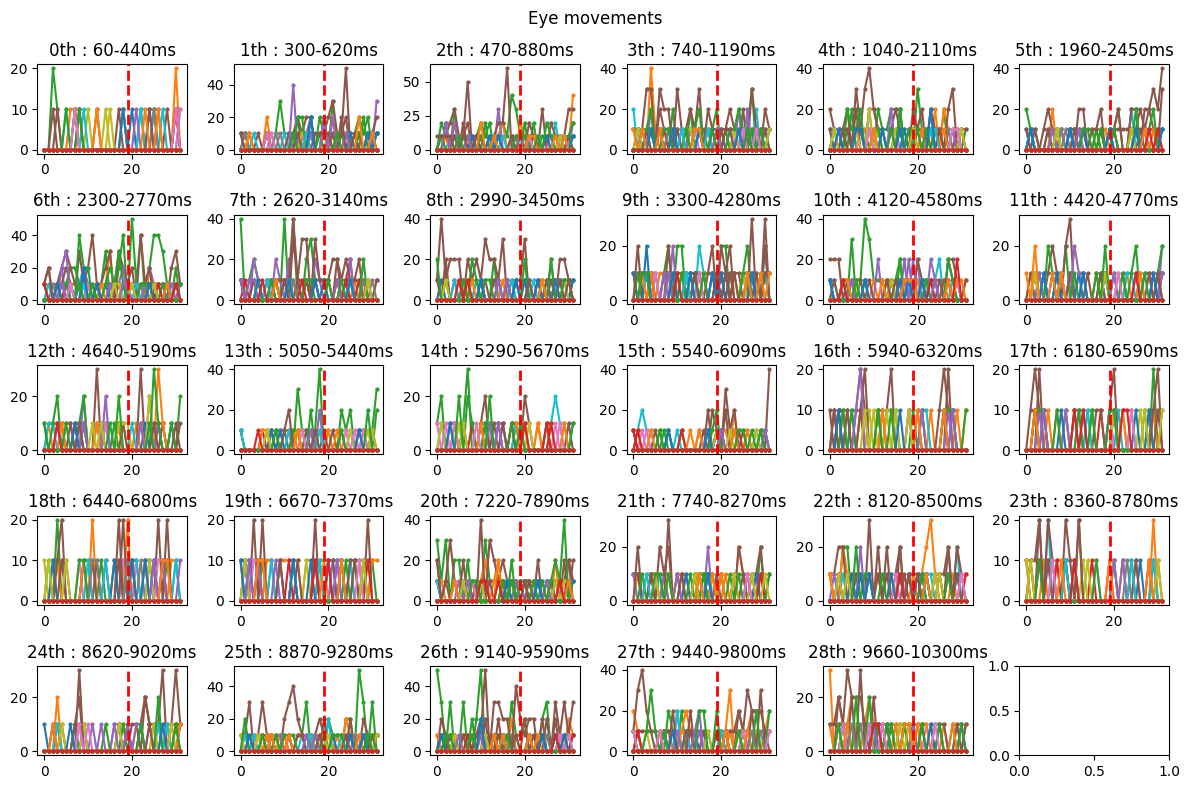

In [104]:
n_plots = len(non0_fixation_neural)
n_cols = int(np.ceil(np.sqrt(n_plots)))
n_rows = int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axes_flat = axes.ravel()
n_fixations = fixations_neural_aligned.shape[2]
#xticks = range(-200, (min_fixation_length - 20)*10, 10)
for idx in range(n_fixations):
    fixation = fixations_neural_aligned[:,:,idx]
    axes_flat[idx].plot(fixation.T * 100, marker="o", markersize=2)
    axes_flat[idx].axvline(x=19, color='red', linestyle='--', linewidth=2)
    axes_flat[idx].set_title(f"{idx}th : {onsets_offsets[idx][0]*10}-{onsets_offsets[idx][1]*10}ms")
plt.suptitle("Eye movements")
plt.tight_layout()  # automatically adjusts spacing
plt.show()

# crop timepts to the min val and then plot the responses altogether and different from the other